# Using RDA APIs getMetadata and getRIFCS to investigate DirectDownloads

NOTES: multiple-word search terms in the API queries need to be enclosed within url-coded quotation marks, written "%22"

In [52]:
#setup
library(httr)
library(xml2)
library(dplyr)
library(ggplot2)



I've defined a couple of little functions that talk to the RDA APIs getMetadata and getRIFCS. They take in query parameters and format the returned JSON/xml as something easier to interrogate in R

In [53]:
#function to make a getMetadata API query
getMetadata <- function(key, q, fl, start, rows){
  url <- paste0("https://researchdata.ands.org.au/registry/services/", key, "/getMetadata.json?", q, "&", fl, "&", start, "&", rows)
  tidyUrl <- gsub(" ", "%20", url)
  resp <- GET(tidyUrl)
  
  out <- jsonlite::fromJSON(content(resp, "text"), simplifyVector = FALSE)	
  print(out$status)
  print(paste(out$message$numFound, "records found"))
  print(paste(length(out$message$docs), "records returned"))
  print(paste("start =", out$message$start))
  out
}

In [54]:
#function to make a getRIFCS API query
getRIFCS <- function(key, q, start, rows){
  url <- paste0("https://researchdata.ands.org.au/registry/services/", key, "/getRIFCS?", q, "&", start, "&", rows)
  tidyUrl <- gsub(" ", "%20", url)
  resp <- GET(tidyUrl)
  
  out <- as_list(read_xml(resp))
  print(paste(length(out$registryObjects), "records returned"))
  out
}

q defines the query, and start and rows page through the returned records. getMetadata returns fields specified by the fl parameter, whereas getRIFCS returns the entire RIFCS record. 

In [55]:
#example queries:
key <- "2a3d5f332582"
q <- "q=access_methods_ss:(directDownload) AND class:(collection)"
fl <- "fl=group_search,access_methods_ss"
start <- "start=0"
rows <- "rows=20"

x <- getMetadata(key, q, fl, start, rows)


No encoding supplied: defaulting to UTF-8.


[1] "success"
[1] "8945 records found"
[1] "20 records returned"
[1] "start = 0"


In [56]:
y <- getRIFCS(key, q, start, rows)

[1] "20 records returned"


___
I started by comparing the number of records marked as directDownload to the number marked as landingPage

In [57]:
#find the number of records marked with directDownload access
key <- "2a3d5f332582"
q <- "q=access_methods_ss:(directDownload) AND class:(collection)"
fl <- "fl=group_search,access_methods_ss"
start <- "start=0"
rows <- "rows=20"
x <- getMetadata(key, q, fl, start, rows)

No encoding supplied: defaulting to UTF-8.


[1] "success"
[1] "8945 records found"
[1] "20 records returned"
[1] "start = 0"


In [58]:
#find the number of records marked with landingPage access
key <- "2a3d5f332582"
q <- "q=access_methods_ss:(landingPage) AND class:(collection)"
fl <- "fl=group_search,access_methods_ss"
start <- "start=0"
rows <- "rows=20"
x <- getMetadata(key, q, fl, start, rows)

No encoding supplied: defaulting to UTF-8.


[1] "success"
[1] "48661 records found"
[1] "20 records returned"
[1] "start = 0"


___
Then I broke down the directDownload records by submitting group

In [59]:
#summarise the groups with directDownload records
key <- "2a3d5f332582"
q <- "q=access_methods_ss:(directDownload) AND class:(collection)"
fl <- "fl=group_search,access_methods_ss"
start <- "start=0"
rows <- "rows=9000"

x <- getMetadata(key, q, fl, start, rows)

#list the group for each record returned:

#find the number of records returned
numRec <- length(x$message$docs)
groups <-vector(length = numRec, mode = "character")

#iterate through the records pulling the group
for(i in 1:numRec){
  groups[i] <- x$message$docs[[i]]$group_search
}

groups <- as.data.frame(groups)
groups <- group_by(groups, groups)

summarise(groups, n = n())

No encoding supplied: defaulting to UTF-8.


[1] "success"
[1] "8945 records found"
[1] "8945 records returned"
[1] "start = 0"


groups,n
<fct>,<int>
ARC Centre of Excellence for Climate System Science,34
Australian Institute of Marine Science,971
Australian Ocean Data Network,1487
Australian Urban Research Infrastructure Network (AURIN),5097
CLEX,3
eAtlas,135
Integrated Marine Observing System,977
University of New South Wales,18
University of Southern Queensland,1


___
We want to investigate the supplied directDownload links: the function below runs through the directDownload records supplied by a group and finds the unique key for the record, the number of electronic addresses supplied, the number of directDownload addresses supplied, and one of those directDownload addresses (in cases where there is more than one, currently it records the last one given). 

In [60]:
#function to find the download location given for each of a group's records:

findDirectDownloads <- function(group, numRows){
  
  key <- "2a3d5f332582"
  q <- paste0("q=access_methods_ss:(directDownload) AND class:(collection) AND group_search:(%22", group, "%22)")
  start <- "start=0"
  rows <- paste0("rows=", numRows)
  
  x <- getRIFCS(key, q, start, rows)
  
  downloadInfo <- data.frame(matrix(nrow = length(x$registryObjects), ncol = 5))
  names(downloadInfo) <- c("key", "name", "numberElectronicAddresses", "numberDirectDownload", "directDownloadAddress")
  for(i in 1:length(x$registryObjects)){
    downloadInfo[i,1] <- x$registryObjects[i]$registryObject$key[[1]]
    downloadInfo[i,2] <- x$registryObjects[i]$registryObject$collection$name$namePart[[1]]
    
    #we want to find the address for the "electronic" elements which have been tagged as "directDownload".
    
    #each collection can contain multiple location elements, each of which can contain multiple address elements,
    #each of which can contain multiple electronic elements. 
  
    #make an empty list to hold all of the electronic elements for this record
    electronicList <- list()
    
    #find all the "location" elements for this record
    locationElements <- which(names(x$registryObjects[[i]]$collection)=="location")
    #for each location element...
    for(l in 1:length(locationElements)){
      #take that element
      currentLocationElement <- x$registryObjects[[i]]$collection[[locationElements[l]]]
      #find all the nested "address" elements 
      addressElements <- which(names(currentLocationElement)=="address")
      #for each address element...
      for(a in 1:length(addressElements)){
        #take that element
        currentAddressElement <- currentLocationElement[[addressElements[a]]]
        #find all the nested "electronic" elements
        electronicElements <- which(names(currentAddressElement)=="electronic")
        #pull them into a list
        electronicOnly <- currentAddressElement[electronicElements]
        #and append that list onto the overall list of electronic elements for this record
        electronicList <- c(electronicList, electronicOnly)
      }
    }
    
    #record the number of electronic address location elements
    downloadInfo[i,3] <- length(electronicList)
    
    #count the number of these that are tagged as directDownload
    isDirect <- function(inputElement){
      if(is.null(attributes(inputElement)$target)){
        FALSE
        }else{
        attributes(inputElement)$target == "directDownload"
      }
    }
    downloadInfo[i,4] <- sum(sapply(electronicList, isDirect))
    
    #run through the list of electronic elements until you find a directDownload one and copy out the url
    #note - this will currently overwrite with any subsequent directDownload elements for this record,
    #so what is written here will be the last directDownload element. 
    for(j in 1:length(electronicList)){
      if (is.null(attributes(electronicList[[j]])$target)){
        #if this element doesn't have a target attribute, don't do anything about it
      }else{
        if (attributes(electronicList[[j]])$target == "directDownload"){
          downloadInfo[i,5] <- electronicList[[j]]$value[[1]]
        }
      }
    }
  }
  downloadInfo
}


In [61]:
CSS <- findDirectDownloads("ARC Centre of Excellence for Climate System Science", 5100)
AIMS <- findDirectDownloads("Australian Institute of Marine Science", 5100)
AODN <- findDirectDownloads("Australian Ocean Data Network", 5100)
AURIN <- findDirectDownloads("Australian Urban Research Infrastructure Network (AURIN)", 5100)
CLEX <- findDirectDownloads("CLEX", 5100)
eAtlas <- findDirectDownloads("eAtlas", 5100)
IMOS <- findDirectDownloads("Integrated Marine Observing System", 5100)
UNSW <- findDirectDownloads("University of New South Wales", 5100)
USQ <- findDirectDownloads("University of Southern Queensland", 5100)
UTas <- findDirectDownloads("University of Tasmania, Australia", 5100)
VU <- findDirectDownloads("Victoria University", 5100)

[1] "34 records returned"
[1] "971 records returned"
[1] "1487 records returned"
[1] "5097 records returned"
[1] "3 records returned"
[1] "135 records returned"
[1] "977 records returned"
[1] "18 records returned"
[1] "1 records returned"
[1] "221 records returned"
[1] "1 records returned"


____

The directDownload targets supplied should be different for each record. Here we can see that there are some duplicated targets for most groups, and some serious issues for some groups (e.g. AURIN has supplied the same directDownload target for 5097 records...)

In [137]:
#this function counts the number of unique directDownload targets:
countUnique <- function(group){
    #list unique directDownload addresses
    uniqueAddrs <- unique(group$directDownloadAddress)
    countTimesAppears <- function(x){
        if(is.na(x)){
            0
        }else{
            sum(group$directDownloadAddress == x, na.rm = T)
        }
    }
    numTimesAppears <- sapply(uniqueAddrs, countTimesAppears)
    print(paste0(deparse(substitute(group)), ": ", sum(numTimesAppears == 1), 
                 " unduplicated of ", length(group$directDownloadAddress)))
}

In [138]:
print("number of unduplicated directDownload target addresses")
countUnique(CSS)
countUnique(AIMS)
countUnique(AODN)
countUnique(AURIN)
countUnique(CLEX)
countUnique(eAtlas)
countUnique(IMOS)
countUnique(UNSW)
countUnique(USQ)
countUnique(UTas)
countUnique(VU)

[1] "number of unduplicated directDownload target addresses"
[1] "CSS: 31 unduplicated of 34"
[1] "AIMS: 956 unduplicated of 971"
[1] "AODN: 1248 unduplicated of 1487"
[1] "AURIN: 0 unduplicated of 5097"
[1] "CLEX: 3 unduplicated of 3"
[1] "eAtlas: 135 unduplicated of 135"
[1] "IMOS: 762 unduplicated of 977"
[1] "UNSW: 18 unduplicated of 18"
[1] "USQ: 1 unduplicated of 1"
[1] "UTas: 212 unduplicated of 221"
[1] "VU: 1 unduplicated of 1"


___
Something to note here is that some records have more than one directDownload link and we've only been looking at the last one listed, so we may not be seeing all the unique links: I've shown how many of the records have multiple directDownload links here.

In [64]:
#function to find out how many records have more than one directDownload link
multipleDirect <- function(group){
  print(paste0(deparse(substitute(group)), ": ", sum(group$numberDirectDownload > 1)))
}

In [66]:
multipleDirect(CSS)
multipleDirect(AIMS)
multipleDirect(AODN)
multipleDirect(AURIN)
multipleDirect(CLEX)
multipleDirect(eAtlas)
multipleDirect(IMOS)
multipleDirect(UNSW)
multipleDirect(USQ)
multipleDirect(UTas)
multipleDirect(VU)

[1] "CSS: 0"
[1] "AIMS: 962"
[1] "AODN: 1061"
[1] "AURIN: 0"
[1] "CLEX: 0"
[1] "eAtlas: 53"
[1] "IMOS: 762"
[1] "UNSW: 5"
[1] "USQ: 0"
[1] "UTas: 51"
[1] "VU: 0"


In [78]:
#function to plot the number of directDownload links per record
plotMultipleDirect <- function(group){
    counts <- table(group$numberDirectDownload)
    barplot(counts, main=deparse(substitute(group)))
}   

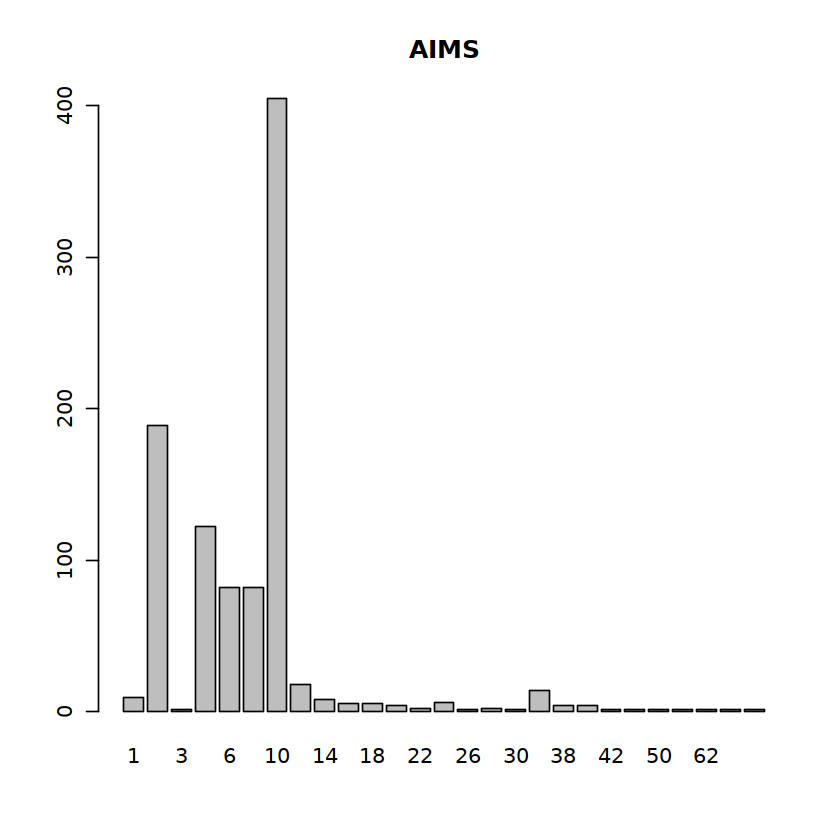

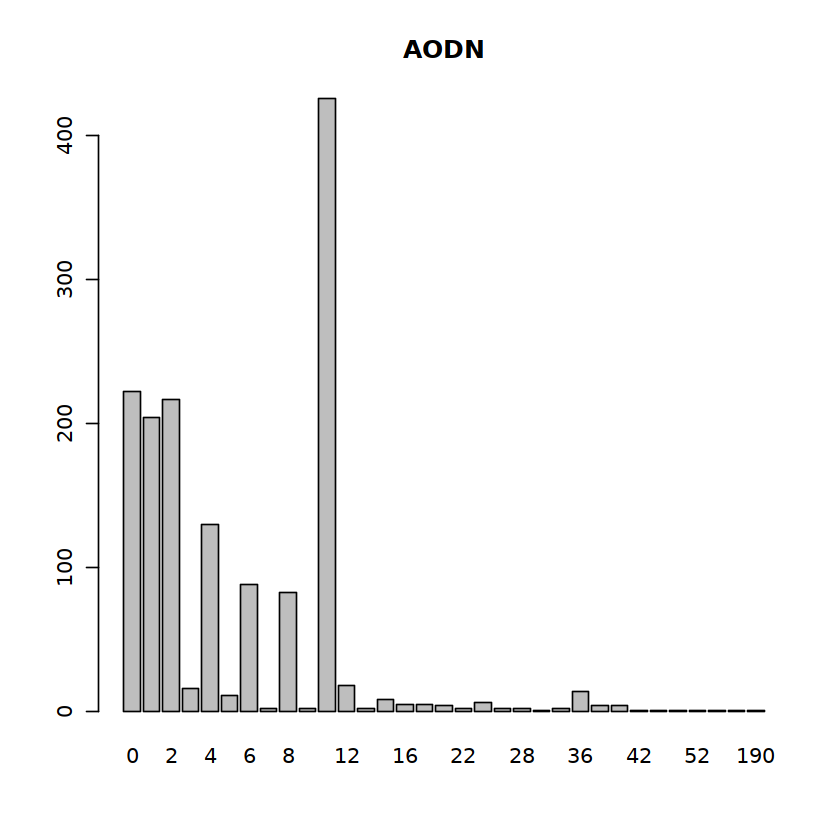

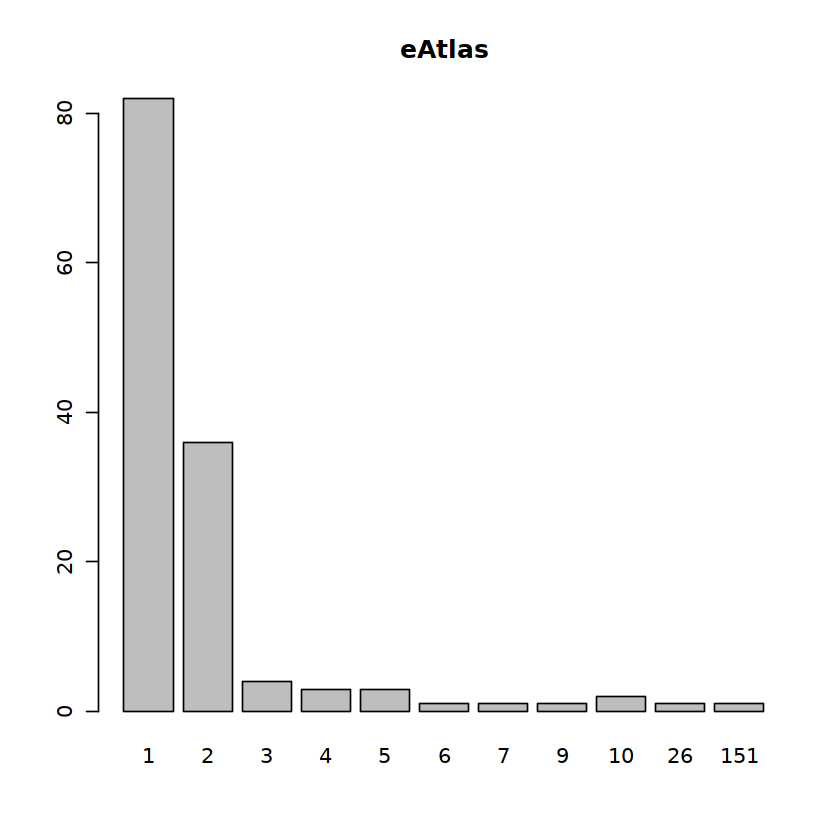

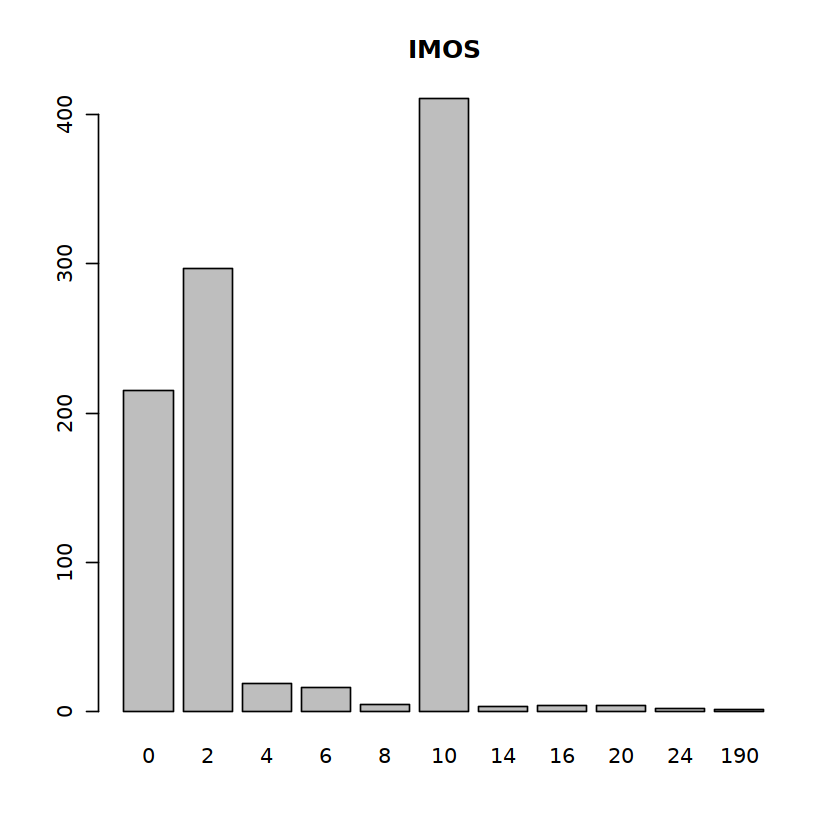

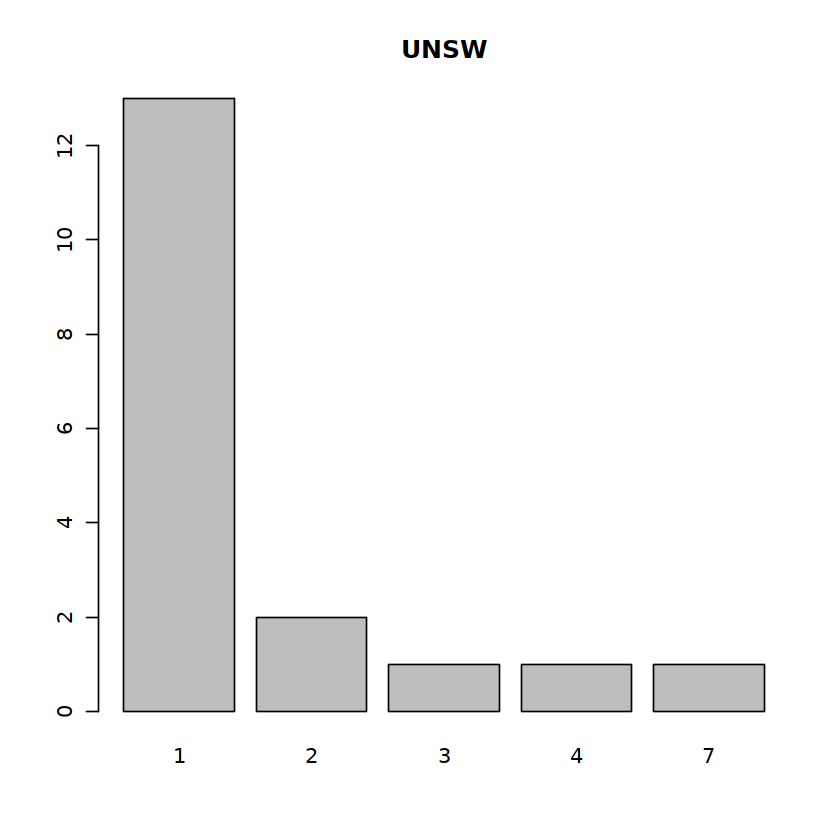

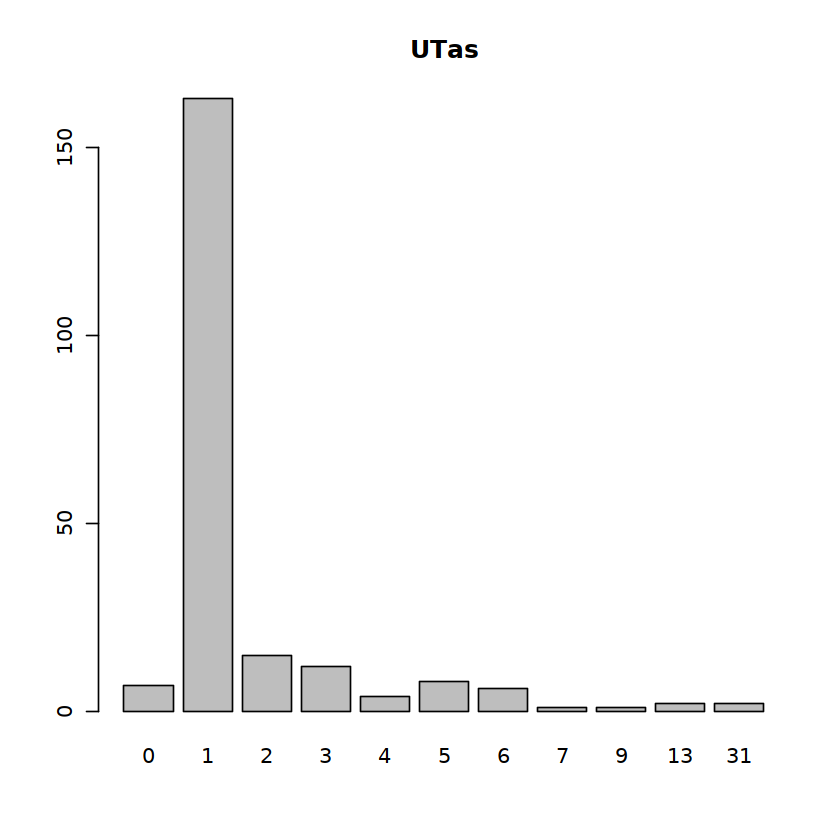

In [79]:
plotMultipleDirect(AIMS)
plotMultipleDirect(AODN)
plotMultipleDirect(eAtlas)
plotMultipleDirect(IMOS)
plotMultipleDirect(UNSW)
plotMultipleDirect(UTas)

___
We also notice above that some records returned in our search for access method: direct download don't have an address element marked directDownload at all (we're investigating why that might be) - this is a count of how often that occurs for each group

In [80]:
#function to find out how many records have zero directDownload links 
noDirect <- function(group){
  print(paste0(deparse(substitute(group)), ": ", sum(group$numberDirectDownload == 0)))
}

In [81]:
noDirect(CSS)
noDirect(AIMS)
noDirect(AODN)
noDirect(AURIN)
noDirect(CLEX)
noDirect(eAtlas)
noDirect(IMOS)
noDirect(UNSW)
noDirect(USQ)
noDirect(UTas)
noDirect(VU)

[1] "CSS: 0"
[1] "AIMS: 0"
[1] "AODN: 222"
[1] "AURIN: 0"
[1] "CLEX: 0"
[1] "eAtlas: 0"
[1] "IMOS: 215"
[1] "UNSW: 0"
[1] "USQ: 0"
[1] "UTas: 7"
[1] "VU: 0"
